<a href="https://colab.research.google.com/github/sebasgavi006/RNA_Algoritmos_Bioinspirados/blob/main/Colonia_de_hormigas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random as rn
import numpy as np
from numpy.random import choice as np_choice

class AntColony(object):

    def __init__(self, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_iteration (int): Number of iterations
            decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1

        Example:
            ant_colony = AntColony(german_distances, 100, 20, 2000, 0.95, alpha=1, beta=2)
        """
        self.distances  = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self):
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            print (shortest_path)
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path
            self.pheromone = self.pheromone * self.decay
        return all_time_shortest_path

    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0
        row = pheromone ** self.alpha * ((1.0 / (dist + 1e-10)) ** self.beta)
        norm_row = row / row.sum()
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move

    def get_optimal_route_info(self, optimal_route):
        """
        Obtener información detallada sobre la ruta óptima.

        Args:
            optimal_route (tuple): Ruta óptima devuelta por el método run.

        Returns:
            list: Lista de tuplas, donde cada tupla contiene el nombre de la ciudad y su costo.
        """
        route_indices, total_distance = optimal_route
        route_info = []

        for i in range(len(route_indices) - 1):
            start_city_index, end_city_index = route_indices[i]
            start_city = self.all_inds[start_city_index]
            end_city = self.all_inds[end_city_index]
            distance = self.distances[start_city_index][end_city_index]
            route_info.append((start_city, end_city, distance))

        # Añadir el último paso de vuelta al inicio
        start_city_index, end_city_index = route_indices[-1]
        start_city = self.all_inds[start_city_index]
        end_city = self.all_inds[end_city_index]
        distance = self.distances[start_city_index][end_city_index]
        route_info.append((start_city, end_city, distance))

        return route_info


In [2]:
import pandas as pd
#Obtenemos el dataset
datos = pd.read_csv('Costo_total.csv')

#Acceder a los datos
print(datos)

      Unnamed: 0    Palmira      Pasto      Tuluá     Bogota    Pereira  \
0        Palmira       0,00  163364,69   48356,96  224037,72   99945,82   
1          Pasto  163364,69       0,00  186702,76  361531,41  237775,27   
2          Tuluá   48356,96  186702,76       0,00  249637,40   53706,56   
3         Bogota  224037,72  361531,41  249637,40       0,00  183054,54   
4        Pereira   99945,82  237775,27   53706,56  183054,54       0,00   
5        Armenia   91029,29  229964,46   65048,09  137066,25   28356,85   
6      Manizales  140605,62  287432,68  103963,96  131220,89   51484,05   
7     Valledupar  451930,49  618118,10  414918,19  329495,44  350081,83   
8       Montería  407658,34  545567,32  349662,76  371296,45  307626,77   
9        Soledad  527610,73  643411,59  471839,76  382921,64  416518,51   
10     Cartagena  499242,23  638264,34  471964,55  398669,98  415874,59   
11  Barranquilla  503111,56  650575,32  627931,45  399236,10  441845,49   
12      Medellín  205798,

In [3]:
#Convertimos el dataset a una matriz numpy
ciudades = datos.iloc[:, 1:].apply(lambda x: x.str.replace(',', '.')).values.astype(float)

#Imprimir la matriz para verificar
print(ciudades)

[[     0.   163364.69  48356.96 224037.72  99945.82  91029.29 140605.62
  451930.49 407658.34 527610.73 499242.23 503111.56 205798.25 326404.06
  404758.79]
 [163364.69      0.   186702.76 361531.41 237775.27 229964.46 287432.68
  618118.1  545567.32 643411.59 638264.34 650575.32 354530.17 465323.69
  533085.9 ]
 [ 48356.96 186702.76      0.   249637.4   53706.56  65048.09 103963.96
  414918.19 349662.76 471839.76 471964.55 627931.45 167213.8  493613.76
  374823.4 ]
 [224037.72 361531.41 249637.4       0.   183054.54 137066.25 131220.89
  329495.44 371296.45 382921.64 398669.98 399236.1  208327.08 184579.32
  206561.43]
 [ 99945.82 237775.27  53706.56 183054.54      0.    28356.85  51484.05
  350081.83 307626.77 416518.51 415874.59 441845.49 117176.45 232641.24
  310823.42]
 [ 91029.29 229964.46  65048.09 137066.25  28356.85      0.    79125.17
  352951.56 319988.41 422595.84 415618.3  430933.49 145261.13 234753.09
  312668.68]
 [140605.62 287432.68 103963.96 131220.89  51484.05  79125

In [13]:
ant_colony = AntColony(ciudades,300,200,200, 0.95, alpha=1, beta=1)
shortest_path = ant_colony.run()
print ("shorted_path: {}".format(shortest_path))

([(0, 3), (3, 6), (6, 5), (5, 12), (12, 8), (8, 7), (7, 11), (11, 9), (9, 10), (10, 13), (13, 14), (14, 4), (4, 2), (2, 1), (1, 0)], 2200468.23)
([(0, 4), (4, 5), (5, 6), (6, 12), (12, 3), (3, 14), (14, 13), (13, 7), (7, 11), (11, 9), (9, 10), (10, 8), (8, 2), (2, 1), (1, 0)], 2007709.8699999999)
([(0, 1), (1, 2), (2, 4), (4, 12), (12, 13), (13, 14), (14, 10), (10, 11), (11, 9), (9, 7), (7, 8), (8, 5), (5, 3), (3, 6), (6, 0)], 2119884.3400000003)
([(0, 3), (3, 14), (14, 13), (13, 7), (7, 10), (10, 11), (11, 9), (9, 8), (8, 1), (1, 5), (5, 4), (4, 6), (6, 12), (12, 2), (2, 0)], 2190264.82)
([(0, 1), (1, 5), (5, 4), (4, 12), (12, 10), (10, 11), (11, 9), (9, 8), (8, 7), (7, 13), (13, 14), (14, 3), (3, 6), (6, 2), (2, 0)], 2097539.9499999997)
([(0, 4), (4, 5), (5, 2), (2, 1), (1, 6), (6, 12), (12, 8), (8, 11), (11, 9), (9, 10), (10, 7), (7, 14), (14, 13), (13, 3), (3, 0)], 2003531.0299999998)
([(0, 1), (1, 6), (6, 4), (4, 12), (12, 8), (8, 9), (9, 11), (11, 10), (10, 14), (14, 7), (7, 13),

#Creacion del gif

In [14]:
# Crear un diccionario que mapee los índices de las ciudades a sus nombres
city_index_to_name = {i: city_name for i, city_name in enumerate(datos.columns[1:])}

# Obtenemos la info de la ruta mas optima
optimal_route_info = ant_colony.get_optimal_route_info(shortest_path)
costo_total = 0
print("Informacion Sobre la Ruta Óptima Tomada:")
for i, move_info in enumerate(optimal_route_info):
    # Obtenemos la información sobre el desplazamiento
    start_city_index, end_city_index, distance = move_info

    # Obtenemos los nombres de las ciudades a partir de los índices
    start_city = city_index_to_name[start_city_index]
    end_city = city_index_to_name[end_city_index]

    # Actualizar el costo total
    costo_total += distance

    # Imprimir la información detallada del desplazamiento
    print(f"Desplazamiento {i + 1}: De {start_city} a {end_city}, Costo: {distance}")
    print(f"Costo total hasta ahora: {costo_total}")


Informacion Sobre la Ruta Óptima Tomada:
Desplazamiento 1: De Palmira a Tuluá, Costo: 48356.96
Costo total hasta ahora: 48356.96
Desplazamiento 2: De Tuluá a Pereira, Costo: 53706.56
Costo total hasta ahora: 102063.51999999999
Desplazamiento 3: De Pereira a Manizales, Costo: 51484.05
Costo total hasta ahora: 153547.57
Desplazamiento 4: De Manizales a Medellín, Costo: 89387.63
Costo total hasta ahora: 242935.2
Desplazamiento 5: De Medellín a Montería, Costo: 212325.65
Costo total hasta ahora: 455260.85
Desplazamiento 6: De Montería a Cartagena, Costo: 140836.76
Costo total hasta ahora: 596097.61
Desplazamiento 7: De Cartagena a Barranquilla, Costo: 57879.54
Costo total hasta ahora: 653977.15
Desplazamiento 8: De Barranquilla a Soledad, Costo: 5655.23
Costo total hasta ahora: 659632.38
Desplazamiento 9: De Soledad a Valledupar, Costo: 127501.03
Costo total hasta ahora: 787133.41
Desplazamiento 10: De Valledupar a Cúcuta, Costo: 184070.61
Costo total hasta ahora: 971204.02
Desplazamiento 

In [15]:
#Instalamos geopandas para graficar el mapa de colombia
!pip install geopandas

<ipython-input-16-c9aacd77c200>:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(colombia_gdf.geometry.centroid.x, colombia_gdf.geometry.centroid.y, colombia_gdf['ADMIN']):


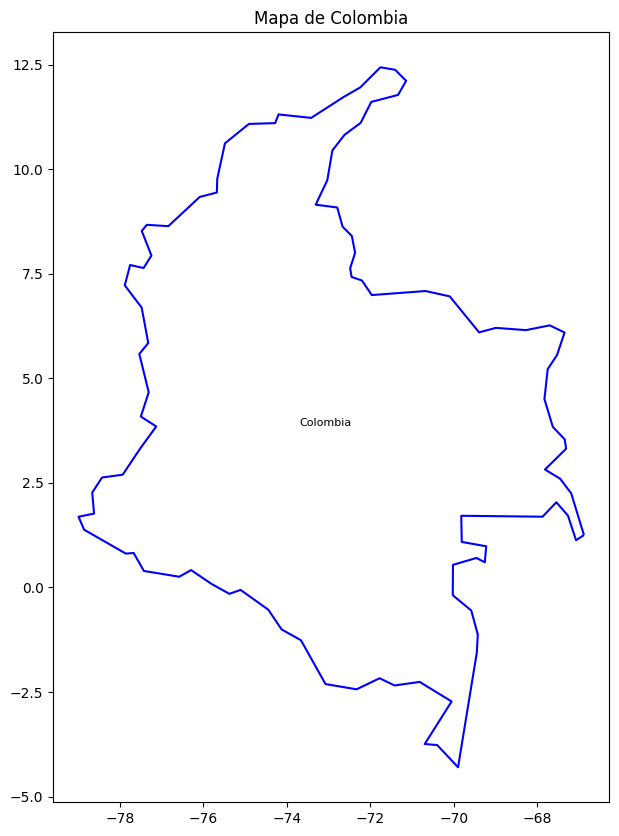

In [16]:
#importamos las librerias que vamos a necesitar para graficar el mapa
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

#Descargamos el archivo geojson con las fronteras de colombia
url = 'https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson'
world_gdf = gpd.read_file(url)

# Filtrar solo el mapa de colombia
colombia_gdf = world_gdf[world_gdf['ADMIN'] == 'Colombia']
# Graficar las fronteras de Colombia
colombia_gdf.boundary.plot(figsize=(10, 10), linewidth=1.5, color='blue')

# Añadir etiquetas
for x, y, label in zip(colombia_gdf.geometry.centroid.x, colombia_gdf.geometry.centroid.y, colombia_gdf['ADMIN']):
    plt.text(x, y, label, fontsize=8, ha='center', va='center')

plt.title('Mapa de Colombia')
plt.show()

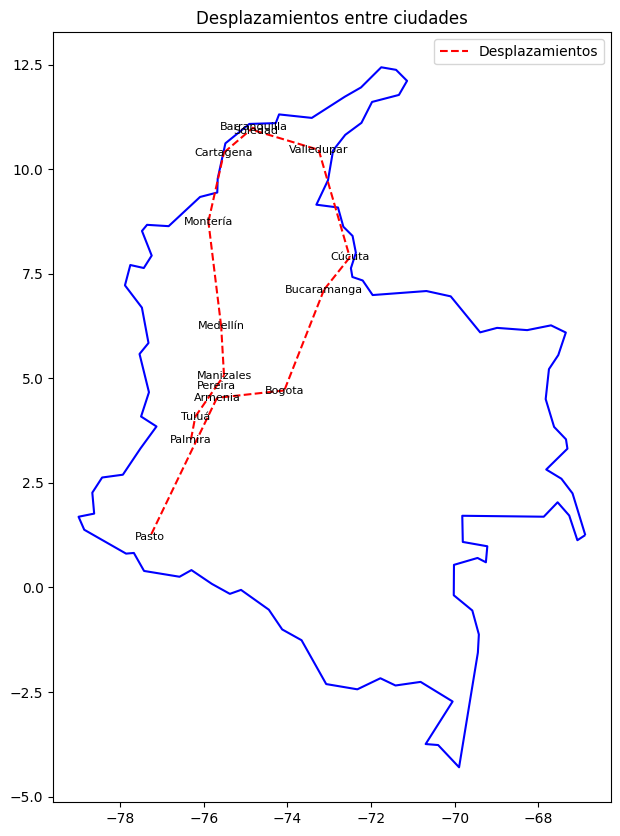

In [17]:
# Crear un GeoDataFrame con las ciudades y sus coordenadas
cities_data = {
    'City': ['Palmira', 'Tuluá', 'Pereira', 'Manizales', 'Medellín', 'Montería', 'Cartagena', 'Barranquilla', 'Soledad', 'Valledupar', 'Cúcuta', 'Bucaramanga', 'Bogota', 'Armenia', 'Pasto'],
    'Latitude': [3.5394, 4.0847, 4.8143, 5.0687, 6.2442, 8.7479, 10.3997, 11.0041, 10.9184, 10.4634, 7.8938, 7.1194, 4.7110, 4.5341, 1.2136],
    'Longitude': [-76.3036, -76.1998, -75.6944, -75.5137, -75.5812, -75.8870, -75.5144, -74.8061, -74.7640, -73.2506, -72.5059, -73.1227, -74.0721, -75.6812, -77.2811]
}

#Ubicamos las ciudades en el geodataframe
cities_gdf = gpd.GeoDataFrame(cities_data, geometry=gpd.points_from_xy(cities_data['Longitude'], cities_data['Latitude']))
#Crear líneas que conectan las ciudades
lines_gdf = gpd.GeoDataFrame(geometry=[LineString([cities_gdf.loc[i, 'geometry'].coords[0], cities_gdf.loc[i + 1, 'geometry'].coords[0]]) for i in range(len(cities_gdf) - 1)])

# Graficar las fronteras de Colombia, las ciudades y las líneas de desplazamiento
fig, ax = plt.subplots(figsize=(10, 10))
colombia_gdf.boundary.plot(ax=ax, linewidth=1.5, color='blue')
lines_gdf.plot(ax=ax, color='red', linewidth=1.5, linestyle='dashed', label='Desplazamientos')

# Añadir etiquetas de las ciudades
for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities_gdf['City']):
    plt.text(x, y, label, fontsize=8, ha='center', va='center')


plt.title('Desplazamientos entre ciudades')
plt.legend()
plt.show()


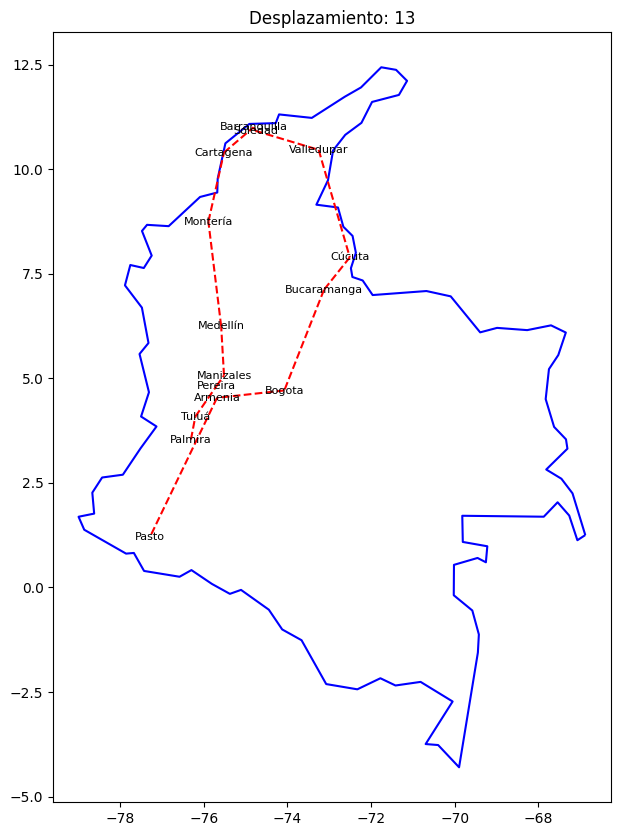

In [18]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 10))

#Funcion para actualizar la figura en cada frame
def update_fig(dplamiento):
    ax.clear()  #Limpiar el eje antes de cada frame
    colombia_gdf.boundary.plot(ax=ax, linewidth=1.5, color='blue')
    lines_gdf[lines_gdf.index <= dplamiento].plot(ax=ax, color='red', linewidth=1.5, linestyle='dashed', label='Desplazamientos')

    #Añadir etiquetas de las ciudades
    for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities_gdf['City']):
        plt.text(x, y, label, fontsize=8, ha='center', va='center')

    ax.set_title(f'Desplazamiento: {dplamiento}')

#Crear la animación
anim = FuncAnimation(fig, update_fig, frames=lines_gdf.index, repeat=False)

#Guardar la animación como un gif
anim.save('desplazamientos1.gif', writer='pillow', fps=1)

plt.show()